# Spatial clustering and denoising expressions

Spatial clustering, which shares an analogy with single-cell clustering, has expanded the scope of tissue physiology studies from cell-centroid to structure-centroid with spatially resolved transcriptomics (SRT) data.

Here, we presented two spatial clustering methods in OmicVerse.

We made three improvements in integrating the `GraphST` and `STAGATE` algorithm in OmicVerse:
- We removed the preprocessing that comes with `GraphST` and used the preprocessing consistent with all SRTs in OmicVerse
- We optimised the dimensional display of `GraphST`, and PCA is considered a self-contained computational step.
- We implemented `mclust` using Python, removing the R language dependency.

If you found this tutorial helpful, please cite `GraphST`, `STAGATE` and OmicVerse:

- Long, Y., Ang, K.S., Li, M. et al. Spatially informed clustering, integration, and deconvolution of spatial transcriptomics with GraphST. Nat Commun 14, 1155 (2023). https://doi.org/10.1038/s41467-023-36796-3
- Dong, K., Zhang, S. Deciphering spatial domains from spatially resolved transcriptomics with an adaptive graph attention auto-encoder. Nat Commun 13, 1739 (2022). https://doi.org/10.1038/s41467-022-29439-6



In [1]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.3, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


## Preprocess data

Here we present our re-analysis of 151676 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

This tutorial demonstrates how to identify spatial domains on 10x Visium data using STAGATE. The processed data are available at https://github.com/LieberInstitute/spatialLIBD. We downloaded the manual annotation from the spatialLIBD package and provided at https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

In [2]:
adata = sc.read_visium(path='data', count_file='151676_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading data/151676_filtered_feature_bc_matrix.h5
 (0:00:00)


<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    We introduced the spatial special svg calculation module prost in omicverse versions greater than `1.6.0` to replace scanpy's HVGs, if you want to use scanpy's HVGs you can set mode=`scanpy` in `ov.space.svg` or use the following code.
  </p>
</div>

```python
#adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
#adata.raw = adata
#adata = adata[:, adata.var.highly_variable_features]
```

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:,adata.var['total_counts']>100]
adata=ov.space.svg(adata,mode='prost',n_svgs=3000,target_sum=1e4,platform="visium",)
adata


Filtering genes ...

Calculating image index 1D:

Normalize each geneing...

Gaussian filtering...


100%|██████████| 5779/5779 [00:19<00:00, 298.99it/s]



Binary segmentation for each gene:


100%|██████████| 5779/5779 [00:20<00:00, 275.49it/s]



Spliting subregions for each gene:


100%|██████████| 5779/5779 [00:48<00:00, 118.36it/s]



Computing PROST Index for each gene:


100%|██████████| 5779/5779 [00:03<00:00, 1607.63it/s]



PROST Index calculation completed !!
PI calculation is done!


100%|██████████| 5779/5779 [03:02<00:00, 31.73it/s]

Spatial autocorrelation test is done!
normalizing counts per cell
    finished (0:00:00)


normalization and log1p are done!


AnnData object with n_obs × n_vars = 3460 × 5779
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'image_idx_1d'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SEP', 'SIG', 'PI', 'Moran_I', 'Geary_C', 'p_norm', 'p_rand', 'fdr_norm', 'fdr_rand', 'space_variable_features'
    uns: 'spatial', 'grid_size', 'locates', 'nor_counts', 'gau_fea', 'binary_image', 'subregions', 'del_index', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [5]:
adata.write('data/cluster_svg.h5ad',compression='gzip')

In [2]:
#adata=ov.read('data/cluster_svg.h5ad',compression='gzip')

(Optional) We read the ground truth area of our spatial data

This step is not mandatory to run, in the tutorial, it's just to demonstrate the accuracy of our clustering effect, and in your own tasks, there is often no Ground_truth

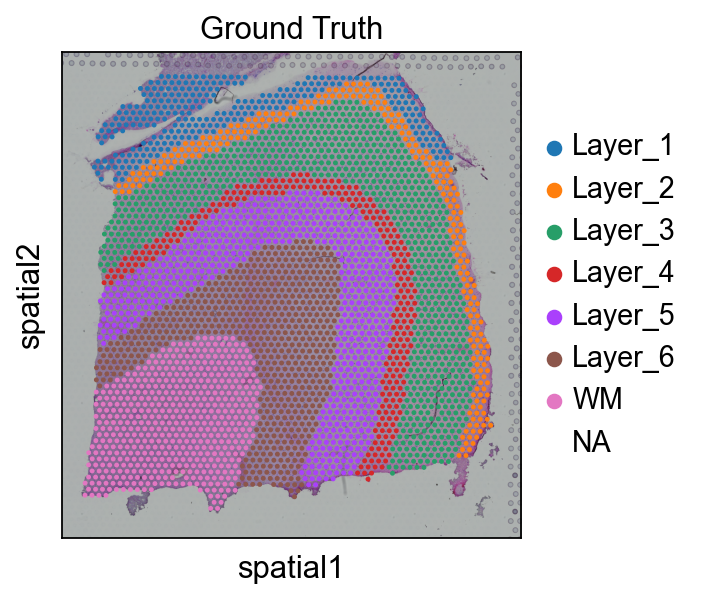

In [3]:
# read the annotation
import pandas as pd
import os
Ann_df = pd.read_csv(os.path.join('data', '151676_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

## GraphST model

GraphST was rated as one of the best spatial clustering algorithms on Nature Method 2024.04, so we first tried to call GraphST for spatial domain identification in OmicVerse.

In [64]:
# define model
model = ov.externel.GraphST.GraphST(adata, device='cuda:0')

# train model
adata = model.train(n_pcs=30)

Begin to train ST data...


100%|██████████| 600/600 [00:09<00:00, 60.39it/s]


Optimization finished for ST data!
GraphST embedding has been saved in adata.obsm["GraphST_embedding"]                         and adata.obsm["graphst|original|X_pca"]


### Clustering the space

We can use `mclust`, `leiden` or `louvain` to cluster the space. 

Note that we also add optimal transport to optimise the distribution of labels, using `refine_label` for that processing.


In [84]:
ov.utils.cluster(adata,use_rep='graphst|original|X_pca',method='mclust',n_components=10,
                 modelNames='EEV', random_state=112,
                )
adata.obs['mclust_GraphST'] = ov.utils.refine_label(adata, radius=50, key='mclust') 

running GaussianMixture clustering
finished: found 10 clusters and added
    'mclust', the cluster labels (adata.obs, categorical)


In [87]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20,
               use_rep='graphst|original|X_pca')
ov.utils.cluster(adata,use_rep='graphst|original|X_pca',method='louvain',resolution=0.7)
ov.utils.cluster(adata,use_rep='graphst|original|X_pca',method='leiden',resolution=0.7)
adata.obs['louvain_GraphST'] = ov.utils.refine_label(adata, radius=50, key='louvain') 
adata.obs['leiden_GraphST'] = ov.utils.refine_label(adata, radius=50, key='leiden') 

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


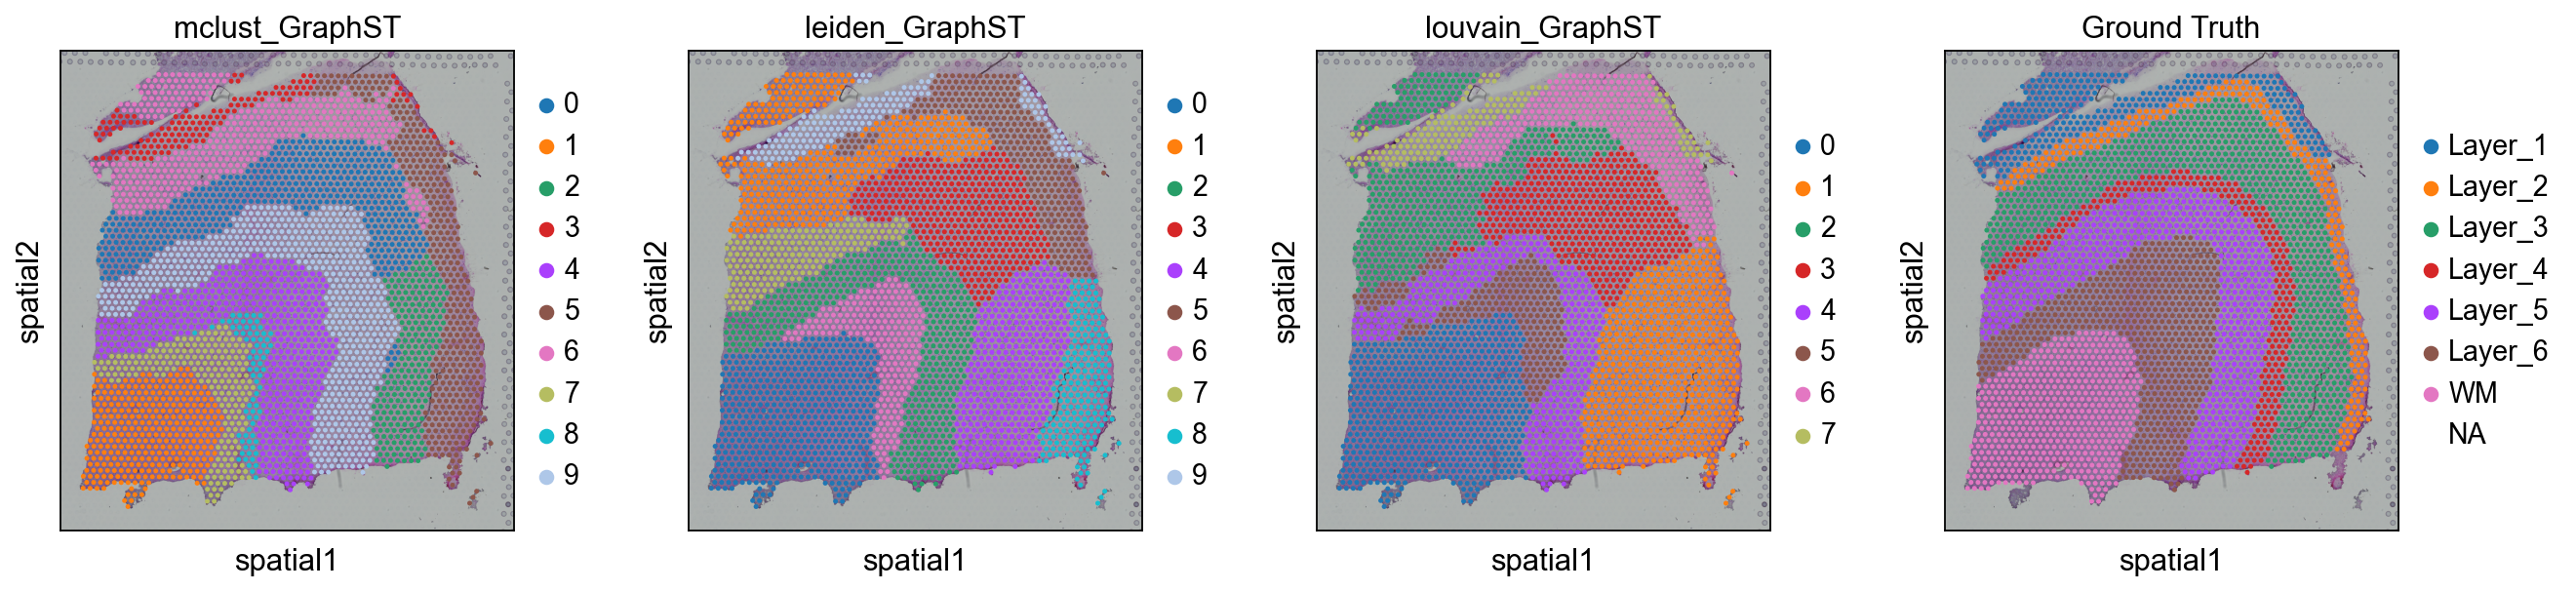

In [88]:
sc.pl.spatial(adata, color=['mclust_GraphST','leiden_GraphST',
                            'louvain_GraphST',"Ground Truth"])

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    If you find that the clustering is mediocre, you might consider re-running `model.train()`. Why the results improve
  </p>
</div>



## STAGATE model

STAGATE is designed for spatial clustering and denoising expressions of spatial resolved transcriptomics (ST) data.

STAGATE learns low-dimensional latent embeddings with both spatial information and gene expressions via a graph attention auto-encoder. The method adopts an attention mechanism in the middle layer of the encoder and decoder, which adaptively learns the edge weights of spatial neighbor networks, and further uses them to update the spot representation by collectively aggregating information from its neighbors. The latent embeddings and the reconstructed expression profiles can be used to downstream tasks such as spatial domain identification, visualization, spatial trajectory inference, data denoising and 3D expression domain extraction.

Dong, Kangning, and Shihua Zhang. “Deciphering spatial domains from spatially resolved transcriptomics with an adaptive graph attention auto-encoder.” Nature Communications 13.1 (2022): 1-12.


Here, we used `ov.space.pySTAGATE` to construct a STAGATE object to train the model. 


In [14]:
#This step sometimes needs to be run twice
#and you need to check that adata.obs['X'] is correctly assigned instead of NA
adata.obs['X'] = adata.obsm['spatial'][:,0]
adata.obs['Y'] = adata.obsm['spatial'][:,1]
adata.obs['X'][0]

9650

------Calculating spatial graph...
The graph contains 3060 edges, 559 cells.
5.4741 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3328 edges, 595 cells.
5.5933 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3448 edges, 613 cells.
5.6248 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3044 edges, 541 cells.
5.6266 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3128 edges, 559 cells.
5.5957 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3320 edges, 595 cells.
5.5798 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


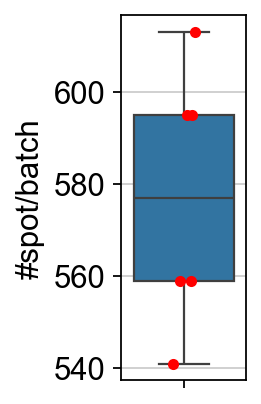

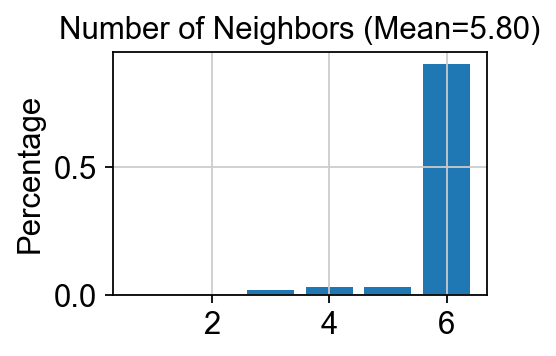

In [15]:
STA_obj=ov.space.pySTAGATE(adata,num_batch_x=3,num_batch_y=2,
                 spatial_key=['X','Y'],rad_cutoff=200,num_epoch = 1000,lr=0.001,
                weight_decay=1e-4,hidden_dims = [512, 30],
                device='cuda:0')

In [16]:
STA_obj.train()

100%|██████████| 1000/1000 [00:28<00:00, 35.02it/s]


We stored the latent embedding in `adata.obsm['STAGATE']`, and denoising expression in `adata.layers['STAGATE_ReX']`

In [17]:
STA_obj.predicted()
adata

The STAGATE representation values are stored in adata.obsm["STAGATE"].
The ReX values are stored in adata.layers["STAGATE_ReX"].


AnnData object with n_obs × n_vars = 3460 × 5779
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'image_idx_1d', 'Ground Truth', 'mclust', 'gmm_cluster', 'mclust_GraphST', 'louvain', 'leiden', 'louvain_GraphST', 'leiden_GraphST', 'X', 'Y'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SEP', 'SIG', 'PI', 'Moran_I', 'Geary_C', 'p_norm', 'p_rand', 'fdr_norm', 'fdr_rand', 'space_variable_features'
    uns: 'binary_image', 'del_index', 'gau_fea', 'grid_size', 'locates', 'log1p', 'nor_counts', 'spatial', 'subregions', 'Ground Truth_colors', 'neighbors', 'louvain', 'leiden', 'mclust_GraphST_colors', 'leiden_GraphST_colors', 'louvain_GraphST_colors', 'Spatia

### Clustering the space


In [18]:
ov.utils.cluster(adata,use_rep='STAGATE',method='mclust',n_components=8,
                 modelNames='EEV', random_state=112,
                )
adata.obs['mclust_STAGATE'] = ov.utils.refine_label(adata, radius=50, key='mclust') 

running GaussianMixture clustering
finished: found 8 clusters and added
    'mclust', the cluster labels (adata.obs, categorical)


In [21]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20,
               use_rep='STAGATE')
ov.utils.cluster(adata,use_rep='STAGATE',method='louvain',resolution=0.5)
ov.utils.cluster(adata,use_rep='STAGATE',method='leiden',resolution=0.5)
adata.obs['louvain_STAGATE'] = ov.utils.refine_label(adata, radius=50, key='louvain') 
adata.obs['leiden_STAGATE'] = ov.utils.refine_label(adata, radius=50, key='leiden') 

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


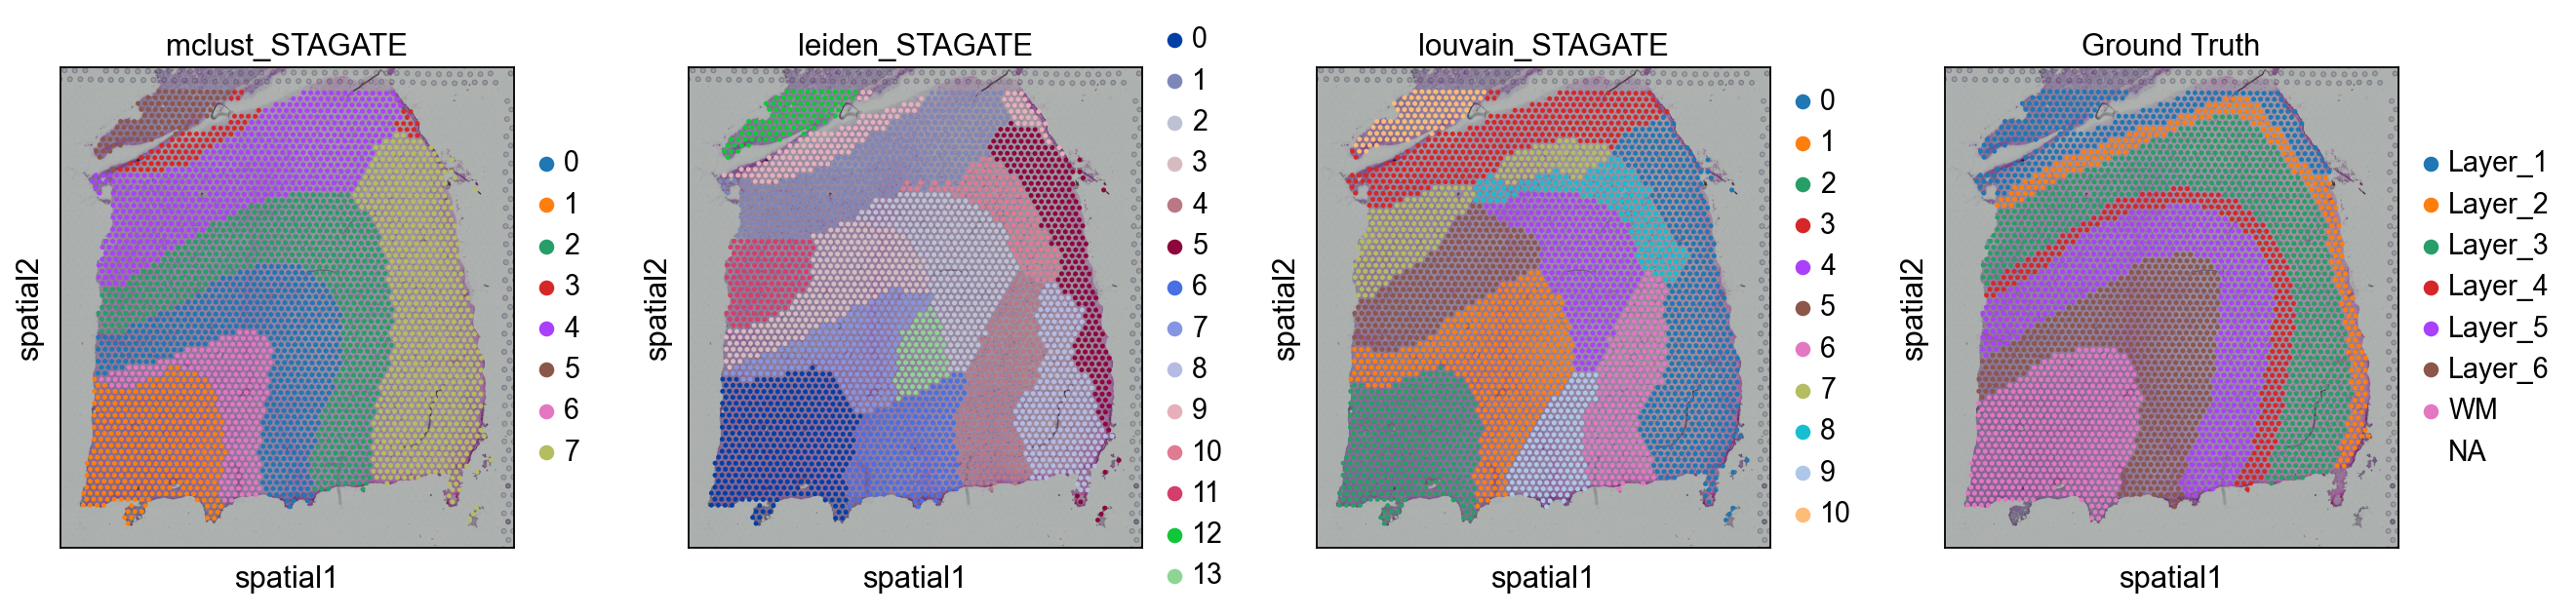

In [22]:
sc.pl.spatial(adata, color=['mclust_STAGATE','leiden_STAGATE',
                            'louvain_STAGATE',"Ground Truth"])

### Denoising

In [23]:
adata.var.sort_values('PI',ascending=False).head(10)

gene_ids    feature_types  genome  n_cells_by_counts  \
MBP      ENSG00000197971  Gene Expression  GRCh38               3411   
GFAP     ENSG00000131095  Gene Expression  GRCh38               2938   
PLP1     ENSG00000123560  Gene Expression  GRCh38               3214   
MT-ND1   ENSG00000198888  Gene Expression  GRCh38               3460   
MT-CO1   ENSG00000198804  Gene Expression  GRCh38               3460   
MT-ATP6  ENSG00000198899  Gene Expression  GRCh38               3460   
CRYAB    ENSG00000109846  Gene Expression  GRCh38               2585   
CNP      ENSG00000173786  Gene Expression  GRCh38               2507   
MT-CO3   ENSG00000198938  Gene Expression  GRCh38               3460   
MT-CO2   ENSG00000198712  Gene Expression  GRCh38               3460   

         mean_counts  log1p_mean_counts  pct_dropout_by_counts  total_counts  \
MBP        15.419075           2.798444               1.416185       53350.0   
GFAP        3.930347           1.595409              15.086705       13599.0   
PLP1        9.255780           2.327842               7.109827       32025.0   
MT-ND1     74.200577           4.320159               0.000000      256734.0   
MT-CO1    115.025436           4.753809               0.000000      397988.0   
MT-ATP6    76.530922           4.350677               0.000000      264797.0   
CRYAB       2.397688           1.223095              25.289017        8296.0   
CNP         2.482948           1.247879              27.543353        8591.0   
MT-CO3     98.956650           4.604737               0.000000      342390.0   
MT-CO2     96.914742           4.584097               0.000000      335325.0   

         log1p_total_counts  n_cells       SEP       SIG        PI   Moran_I  \
MBP               10.884648     3411  0.823299  0.214148  1.000000  0.910362   
GFAP               9.517825     2938  0.694169  0.129941  0.587889  0.743831   
PLP1              10.374304     3214  0.668771  0.099919  0.478698  0.737326   
MT-ND1            12.455800     3460  0.362000  0.163292  0.359299  0.740392   
MT-CO1            12.894179     3460  0.472005  0.100106  0.338241  0.755924   
MT-ATP6           12.486723     3460  0.381374  0.129374  0.322039  0.739112   
CRYAB              9.023649     2585  0.532278  0.065422  0.300814  0.583819   
CNP                9.058587     2507  0.541763  0.056235  0.284438  0.608356   
MT-CO3            12.743709     3460  0.435058  0.083730  0.280653  0.738370   
MT-CO2            12.722858     3460  0.413118  0.086952  0.272313  0.739985   

          Geary_C  p_norm  p_rand  fdr_norm  fdr_rand  space_variable_features  
MBP      0.092733     0.0     0.0       0.0       0.0                     True  
GFAP     0.255528     0.0     0.0       0.0       0.0                     True  
PLP1     0.264750     0.0     0.0       0.0       0.0                     True  
MT-ND1   0.262487     0.0     0.0       0.0       0.0                     True  
MT-CO1   0.246897     0.0     0.0       0.0       0.0                     True  
MT-ATP6  0.261844     0.0     0.0       0.0       0.0                     True  
CRYAB    0.419295     0.0     0.0       0.0       0.0                     True  
CNP      0.392351     0.0     0.0       0.0       0.0                     True  
MT-CO3   0.262784     0.0     0.0       0.0       0.0                     True  
MT-CO2   0.261256     0.0     0.0       0.0       0.0                     True

[<AxesSubplot: title={'center': 'STAGATE_MBP'}, xlabel='spatial1', ylabel='spatial2'>]

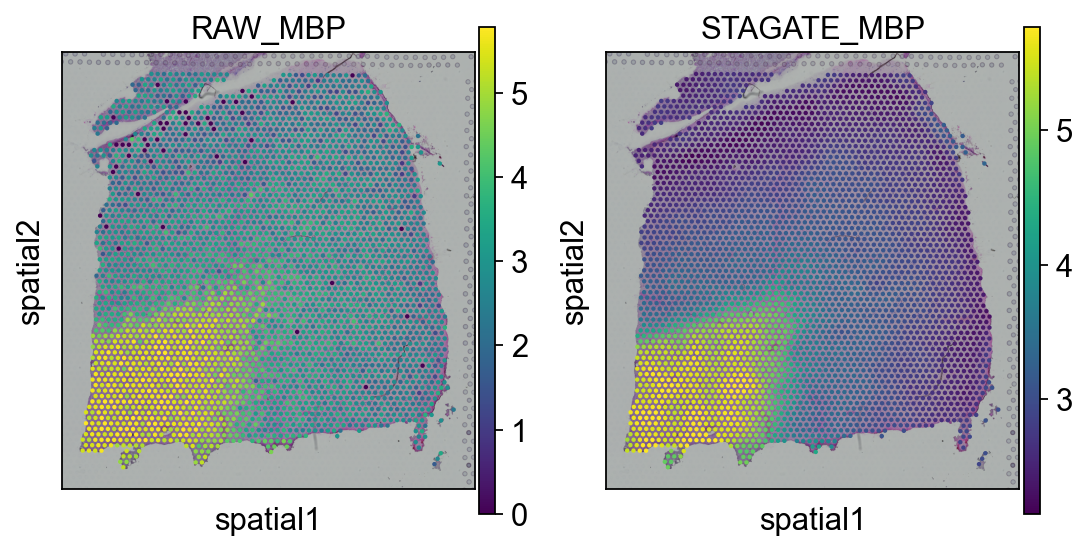

In [24]:
plot_gene = 'MBP'
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')


### Calculated the Pseudo-Spatial Map

We compared the model results from `SpaceFlow` and `STAGATE`, and to our surprise, STAGATE can also be applied to predict pSM.

In [25]:
STA_obj.cal_pSM(n_neighbors=20,resolution=1,
                       max_cell_for_subsampling=5000)
adata

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99851024 0.99476194 0.99319506 0.9898392  0.98800147
     0.98574233 0.98322767 0.9812057  0.97595733 0.97261435 0.9706151
     0.9683451  0.9655115  0.96180284]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigen

AnnData object with n_obs × n_vars = 3460 × 5779
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'image_idx_1d', 'Ground Truth', 'mclust', 'gmm_cluster', 'mclust_GraphST', 'louvain', 'leiden', 'louvain_GraphST', 'leiden_GraphST', 'X', 'Y', 'mclust_STAGATE', 'louvain_STAGATE', 'leiden_STAGATE', 'pSM_STAGATE'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SEP', 'SIG', 'PI', 'Moran_I', 'Geary_C', 'p_norm', 'p_rand', 'fdr_norm', 'fdr_rand', 'space_variable_features'
    uns: 'binary_image', 'del_index', 'gau_fea', 'grid_size', 'locates', 'log1p', 'nor_counts', 'spatial', 'subregions', 'Ground Truth_colors', 'neighbors', 'louvain', 'leiden', 'mclust_Graph

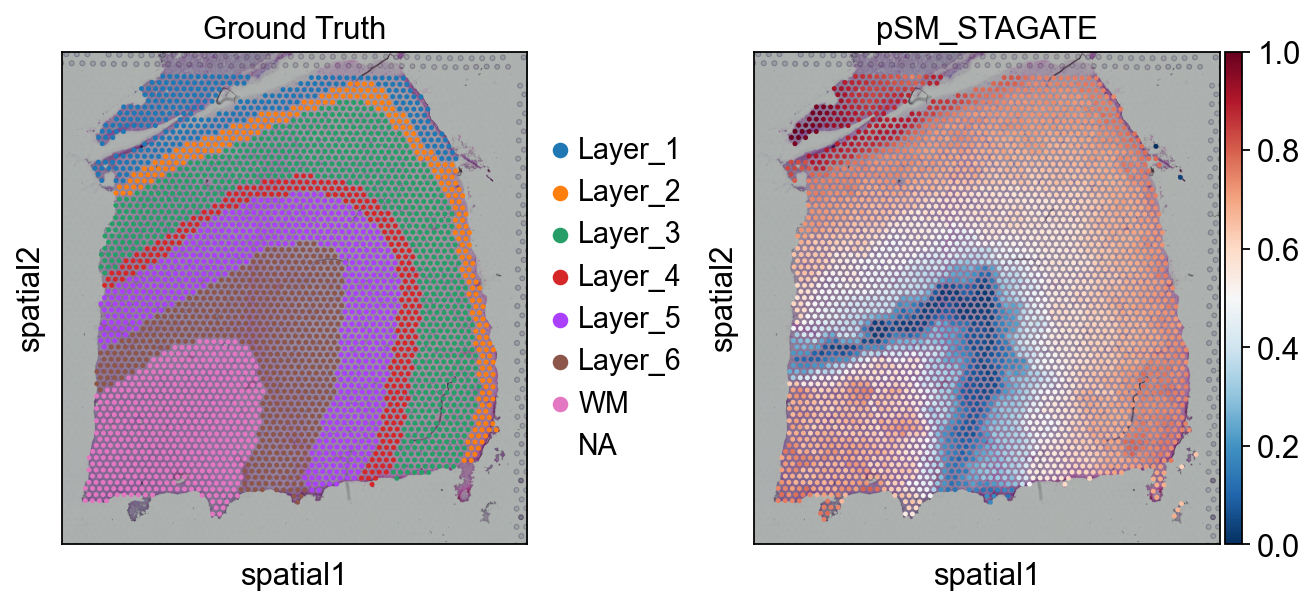

In [26]:
sc.pl.spatial(adata, color=['Ground Truth','pSM_STAGATE'],
             cmap='RdBu_r')

## Evaluate cluster

We use ARI to evaluate the scoring of our clusters against the true values


In [86]:
from sklearn.metrics.cluster import adjusted_rand_score

obs_df = adata.obs.dropna()
#GraphST
ARI = adjusted_rand_score(obs_df['mclust_GraphST'], obs_df['Ground Truth'])
print('mclust_GraphST: Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(obs_df['leiden_GraphST'], obs_df['Ground Truth'])
print('leiden_GraphST: Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(obs_df['louvain_GraphST'], obs_df['Ground Truth'])
print('louvain_GraphST: Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(obs_df['mclust_STAGATE'], obs_df['Ground Truth'])
print('mclust_STAGATE: Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(obs_df['leiden_STAGATE'], obs_df['Ground Truth'])
print('leiden_STAGATE: Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(obs_df['louvain_STAGATE'], obs_df['Ground Truth'])
print('louvain_STAGATE: Adjusted rand index = %.2f' %ARI)

mclust_GraphST: Adjusted rand index = 0.45
leiden_GraphST: Adjusted rand index = 0.37
louvain_GraphST: Adjusted rand index = 0.32
mclust_STAGATE: Adjusted rand index = 0.52
leiden_STAGATE: Adjusted rand index = 0.32
louvain_STAGATE: Adjusted rand index = 0.37


It seems that STAGATE outperforms GraphST on this task, but OmicVerse only provides a unified implementation of the algorithm and does not do a full benchmark of the algorithm.